# Practice Session 05: PageRank

*Introduction to Network Science* (2025/26), UPF

# 1. Read host names

In [6]:
import gzip
import csv
import networkx as nx
import matplotlib.pyplot as plt

In [7]:
INPUT_NODES_FILENAME = "data/webspam-uk2007/webspam_uk2007-nodes.csv.gz"
INPUT_EDGES_FILENAME = "data/webspam-uk2007/webspam_uk2007-edges.csv.gz"

In [8]:
hosts = {}
name2id = {}

with gzip.open(INPUT_NODES_FILENAME, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file)
    for line in reader:
        name_label = {}
        name_label["name"] = line["hostname"]
        name_label["label"] = line["label"]
        id = int(line["nodeid"])
        hosts[id] = name_label
        name2id[line["hostname"]] = id


In [9]:
print("Number of hosts: %s" % len(hosts))
print("%s: %s" % (hosts[873]['name'], hosts[873]['label']))
print("%s: %s" % (hosts[105715]['name'], hosts[105715]['label']))

Number of hosts: 114529
bbc.co.uk: nonspam
www.top-mobile-phones.co.uk: spam


In [10]:
unlabaeled_count = 0
spam_count = 0
nonspam_count = 0

for id, name_label in hosts.items():
    if name_label["label"] == "unlabeled":
        unlabaeled_count += 1
    elif name_label["label"] == "spam":
        spam_count += 1
    elif name_label["label"] == "nonspam":
        nonspam_count += 1
        
print("Unlabeled hosts: %s" % unlabaeled_count, "("+ str(round(unlabaeled_count/len(hosts)*100,2)) + "%)")
print("Spam hosts: %s" % spam_count, "("+ str(round(spam_count/len(hosts)*100,2)) + "%)")
print("Non-spam hosts: %s" % nonspam_count, "("+ str(round(nonspam_count/len(hosts)*100,2)) + "%)")

Unlabeled hosts: 108476 (94.71%)
Spam hosts: 344 (0.3%)
Non-spam hosts: 5709 (4.98%)


In [11]:
spammywords = [
    'credit', 'free', 'mortgage', 'jackpot', 'casino', 'wealthy', 'luxury', 
    'shop', 'replica', 'finance', 'debt', 'loan', 'discount', 'escort', 
    'xx', 'girl', 'mistress', 'important', 'attention']

g = nx.DiGraph()

with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file)
    for row in reader:
        source_id = int(row['source'])
        target_id = int(row['destination'])
        source_name = hosts[source_id]['name']
        target_name = hosts[target_id]['name']

        if (
            (any(word in source_name for word in spammywords)
            or any(word in target_name for word in spammywords))
            and hosts[source_id]['label'] != 'unlabeled'
            and hosts[target_id]['label'] != 'unlabeled'
        ):
            g.add_edge(source_name, target_name)

print("Number of nodes:", g.number_of_nodes())
print("Number of edges:", g.number_of_edges())

Number of nodes: 172
Number of edges: 155


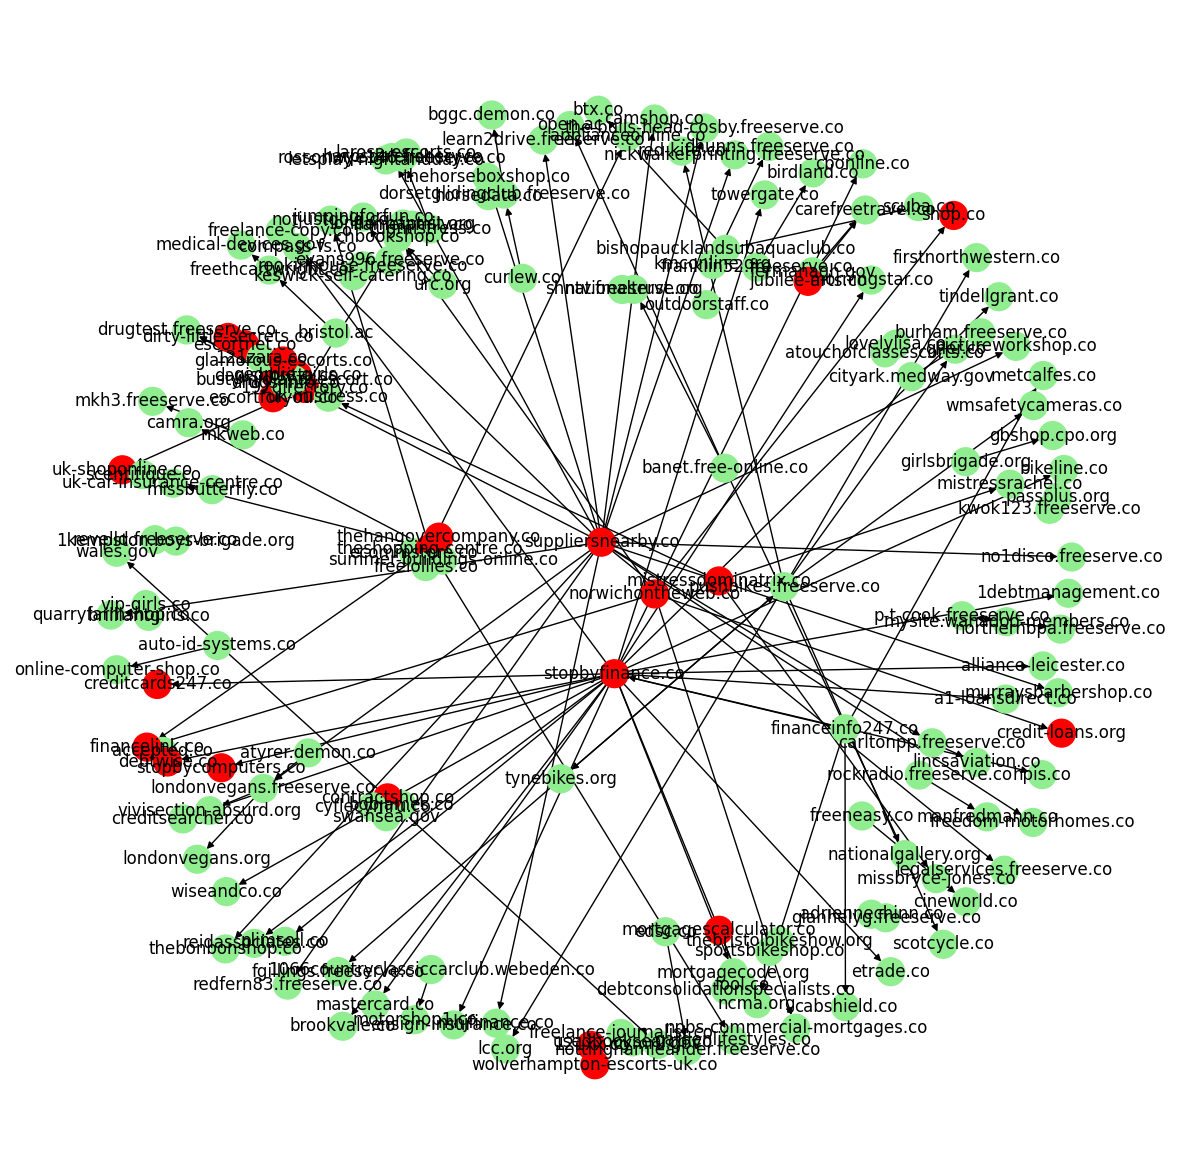

In [12]:
# Leave this code as-is, or modify slightly

colors = []
hostname_converted = {}

for hostname in g.nodes():
    # Assign colors to nodes according to spam/nonspam labels
    if hosts[name2id[hostname]]['label'] == 'spam':
        colors.append('red')
    elif hosts[name2id[hostname]]['label'] == 'nonspam':
        colors.append('lightgreen')
    else:
        colors.append('white')

    # Shorten the hostnames to generate labels
    label = hostname.replace("www.", "").replace(".uk", "")
    hostname_converted[hostname] = label

# Notice that if you re-run this cell the layout will be different every time
plt.figure(figsize=(15, 15))
plt.axis('off')
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos, with_labels=True, node_size=400, node_color=colors, labels=hostname_converted)

In [13]:
spam_edge = 0
spam_nonspam_edge = 0
spam_source_count = 0
nonspam_target_count = 0

for edge in g.edges():
    source_name = edge[0]
    source_id = name2id[source_name]
    if hosts[source_id]['label'] == 'spam':
        spam_edge += 1
p_spam_edge = round(spam_edge / g.number_of_edges(), 4)

for edge in g.edges():
    source_name = edge[0]
    target_name = edge[1]
    source_id = name2id[source_name]
    target_id = name2id[target_name]
    if hosts[source_id]['label'] == 'spam' and hosts[target_id]['label'] == 'nonspam':
        spam_nonspam_edge += 1
p_spam_nonspam_edge = round(spam_nonspam_edge / g.number_of_edges(), 4)

for edge in g.edges():
    source_name = edge[0]
    target_name = edge[1]
    source_id = name2id[source_name]
    target_id = name2id[target_name]
    if hosts[source_id]['label'] == 'spam':
        spam_source_count += 1
        if hosts[target_id]['label'] == 'nonspam':
            nonspam_target_count += 1

pcond_spam_nonspam_edge = round(nonspam_target_count / spam_source_count, 4)


print("P(edge leaving from spammy node): ", p_spam_edge)
print("P(edge pointing from spammy to non-spammy node): ", p_spam_nonspam_edge)
print("P(source is spammy | target is non-spammy): ", pcond_spam_nonspam_edge)

P(edge leaving from spammy node):  0.4968
P(edge pointing from spammy to non-spammy node):  0.3806
P(source is spammy | target is non-spammy):  0.7662


# 2. Compute the degree of each node

In [17]:
id2degree = {}
N = len(hosts)
for nodeid in range(N):
    id2degree[nodeid] = 0

In [18]:
with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file)
    for row in reader:
        source_id = int(row['source'])
        id2degree[source_id] += 1

print(id2degree.values())

dict_values([46, 0, 3, 1, 1, 10, 2, 0, 6, 0, 0, 0, 6, 0, 7, 12, 1, 0, 4, 2, 22, 0, 222, 1, 0, 5, 0, 1, 3, 0, 0, 1, 10, 1, 2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 9, 4, 0, 4, 9, 0, 2, 1, 1, 0, 3, 5, 11, 0, 0, 258, 14, 7, 0, 0, 0, 1, 0, 4, 6, 2, 0, 1, 3, 1, 0, 6, 4, 0, 1, 10, 1, 1, 3, 2, 1, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 4, 0, 0, 6, 1, 0, 2, 3, 8, 32, 1, 1, 0, 0, 4, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 10, 0, 5, 0, 0, 4, 0, 0, 0, 20, 0, 2, 1, 1, 11, 0, 1, 9, 11, 0, 1, 0, 0, 0, 6, 1, 0, 1, 0, 75, 0, 4, 0, 5, 0, 3, 0, 2, 4, 16, 7, 0, 5, 0, 0, 1, 4, 2, 0, 0, 4, 0, 10, 5, 1, 8, 5, 0, 4, 1, 5, 1, 1, 0, 1, 8, 0, 18, 1, 0, 4, 114, 1, 3, 5, 1, 0, 0, 1, 3, 1, 0, 2, 5, 0, 2, 3, 1, 0, 0, 5, 10, 0, 12, 1, 51, 6, 60, 0, 1, 7, 1, 1, 0, 1, 1, 34, 7, 1, 1, 0, 0, 0, 10, 2, 21, 1, 8, 7, 8, 1224, 1, 272, 2, 2, 0, 2, 35, 44, 1, 2, 4, 0, 1, 62, 1, 1, 4, 8, 6, 3, 1, 3, 1, 19, 1, 4, 0, 0, 6, 1, 16, 0, 1, 37, 0, 2, 1, 2, 10, 0, 53, 1, 0, 2, 17, 51, 49, 1, 0, 0, 2, 2, 0, 21, 1, 75, 50, 1, 50, 1, 1, 273,

In [19]:
# test
for nodeid in [61914, 479, 62730]:
    print(f"{hosts[nodeid]['name']}: degree {id2degree[nodeid]}")

www.instrumentfinance.co.uk: degree 262
amazon.co.uk: degree 6
www.iso9000uk.co.uk: degree 38


# 3. Compute PageRank

In [20]:
ITERATIONS = 25
ALPHA = 0.91

pagerank = [1.0/N] * N
pagerank_aux = [0.0] * N

In [21]:
for iteration in range(ITERATIONS):
    print("Iteration", iteration + 1, "of", ITERATIONS)
    out_degree = [0] * N

    # compute out-degrees
    with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as f:
        reader = csv.reader(f)
        next(reader)  # skip header
        for row in reader:
            out_degree[int(row[0])] += 1

    # distribute pagerank
    with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as f:
        reader = csv.reader(f)
        next(reader) # skip header
        for row in reader:
            source, destination = int(row[0]), int(row[1])
            if out_degree[source]:
                pagerank_aux[destination] += pagerank[source] / out_degree[source]


    # update pagerank
    new_pagerank = []
    for i in range(N):
        new_value = ALPHA * pagerank_aux[i] + (1.0 - ALPHA) / N
        new_pagerank.append(new_value)


    #  normalize
    norm = 0.0
    for x in new_pagerank:
        norm += x

    for i in range(N):
        new_pagerank[i] = new_pagerank[i] / norm

    # new delta
    delta = 0.0
    for i in range(N):
        delta += abs(new_pagerank[i] - pagerank[i])

    print("  delta =", round(delta, 4))
    print("    sumPageRank =", round(sum(new_pagerank), 10)) # should be exactly 1
    pagerank, pagerank_aux = new_pagerank, [0.0] * N


Iteration 1 of 25
  delta = 1.1472
    sumPageRank = 1.0
Iteration 2 of 25
  delta = 0.4814
    sumPageRank = 1.0
Iteration 3 of 25
  delta = 0.2268
    sumPageRank = 1.0
Iteration 4 of 25
  delta = 0.1259
    sumPageRank = 1.0
Iteration 5 of 25
  delta = 0.0798
    sumPageRank = 1.0
Iteration 6 of 25
  delta = 0.0548
    sumPageRank = 1.0
Iteration 7 of 25
  delta = 0.04
    sumPageRank = 1.0
Iteration 8 of 25
  delta = 0.0302
    sumPageRank = 1.0
Iteration 9 of 25
  delta = 0.024
    sumPageRank = 1.0
Iteration 10 of 25
  delta = 0.0197
    sumPageRank = 1.0
Iteration 11 of 25
  delta = 0.0169
    sumPageRank = 1.0
Iteration 12 of 25
  delta = 0.0153
    sumPageRank = 1.0
Iteration 13 of 25
  delta = 0.0147
    sumPageRank = 1.0
Iteration 14 of 25
  delta = 0.0146
    sumPageRank = 1.0
Iteration 15 of 25
  delta = 0.0145
    sumPageRank = 1.0
Iteration 16 of 25
  delta = 0.0145
    sumPageRank = 1.0
Iteration 17 of 25
  delta = 0.0146
    sumPageRank = 1.0
Iteration 18 of 25
  delta

# 4. Nodes with largest values of PageRank

In [22]:
def print_top_hosts(hosts, pagerank):
    hosts_by_score = sorted(enumerate(pagerank), key=lambda x: x[1], reverse=True)
    
    print("Top 20 hosts by PageRank:")
    print("{:<5} {:<30} {:>10}".format("Rank", "Host", "PageRank"))
    print("-" * 50)

    for rank, (idx, score) in enumerate(hosts_by_score[:20], start=1):
        print(f"№{rank}. {hosts[idx]["name"]} ({hosts[idx]["label"]}): {score:.6f}")

print_top_hosts(hosts, pagerank)


Top 20 hosts by PageRank:
Rank  Host                             PageRank
--------------------------------------------------
№1. www.opsi.gov.uk (unlabeled): 0.006525
№2. www.ico.gov.uk (unlabeled): 0.003838
№3. www.adobe.co.uk (unlabeled): 0.003396
№4. www.kelkoo.co.uk (unlabeled): 0.003389
№5. www.dti.gov.uk (unlabeled): 0.003127
№6. www.alcoholics-anonymous.org.uk (unlabeled): 0.003107
№7. www.defra.gov.uk (unlabeled): 0.003014
№8. shopping.kelkoo.co.uk (unlabeled): 0.002892
№9. www.aa-roundabout.org.uk (unlabeled): 0.002830
№10. www.direct.gov.uk (unlabeled): 0.002611
№11. www.communities.gov.uk (unlabeled): 0.002606
№12. www.dfes.gov.uk (unlabeled): 0.002486
№13. www.dh.gov.uk (unlabeled): 0.002120
№14. www.hmso.gov.uk (unlabeled): 0.001994
№15. news.bbc.co.uk (unlabeled): 0.001990
№16. www.fsa.gov.uk (unlabeled): 0.001952
№17. www.nationalrail.co.uk (unlabeled): 0.001902
№18. www.homeoffice.gov.uk (unlabeled): 0.001806
№19. www.hse.gov.uk (unlabeled): 0.001733
№20. www.dwp.gov.uk

# 5. Run non-spam PageRank

In [23]:
id2nsdegree = {}

with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file)
    for row in reader:
        idsource = int(row['source'])
        iddestination = int(row['destination'])
        if hosts[idsource]['label'] != "spam" and hosts[iddestination]['label'] != "spam":
            if idsource in id2nsdegree:
                id2nsdegree[idsource] += 1
            else:
                id2nsdegree[idsource] = 1

In [24]:
for nodeid in [61914, 479, 62730]:
    print(f"{hosts[nodeid]['name']}: normal degree {id2degree[nodeid]} nospam degree {id2nsdegree[nodeid]}")

www.instrumentfinance.co.uk: normal degree 262 nospam degree 258
amazon.co.uk: normal degree 6 nospam degree 6
www.iso9000uk.co.uk: normal degree 38 nospam degree 37


In [25]:
ns_pagerank = [1.0 / N] * N
pagerank_aux = [0.0] * N

for iteration in range(ITERATIONS):
    print("Iteration", iteration + 1, "of", ITERATIONS)
    
    # distribute pagerank
    with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            source, destination = int(row['source']), int(row['destination'])

            # skip spam nodes
            if hosts[source]['label'] == "spam" or hosts[destination]['label'] == "spam":
                continue

            # only distribute if source has nonzero out-degree
            if source in id2nsdegree and id2nsdegree[source] > 0:
                pagerank_aux[destination] += ns_pagerank[source] / id2nsdegree[source]

    # update pagerank
    new_pagerank = []
    for i in range(N):
        new_value = ALPHA * pagerank_aux[i] + (1.0 - ALPHA) / N
        new_pagerank.append(new_value)

    # normalize
    norm = sum(new_pagerank)
    new_pagerank = [x / norm for x in new_pagerank]

    # compute delta
    delta = sum(abs(new_pagerank[i] - ns_pagerank[i]) for i in range(N))

    print("  delta =", round(delta, 4))
    print("    sumPageRank =", round(sum(new_pagerank), 10)) # should be exactly 1

    # prepare for next iteration
    ns_pagerank, pagerank_aux = new_pagerank, [0.0] * N

Iteration 1 of 25
  delta = 1.148
    sumPageRank = 1.0
Iteration 2 of 25
  delta = 0.4816
    sumPageRank = 1.0
Iteration 3 of 25
  delta = 0.2267
    sumPageRank = 1.0
Iteration 4 of 25
  delta = 0.126
    sumPageRank = 1.0
Iteration 5 of 25
  delta = 0.0799
    sumPageRank = 1.0
Iteration 6 of 25
  delta = 0.0548
    sumPageRank = 1.0
Iteration 7 of 25
  delta = 0.04
    sumPageRank = 1.0
Iteration 8 of 25
  delta = 0.0303
    sumPageRank = 1.0
Iteration 9 of 25
  delta = 0.024
    sumPageRank = 1.0
Iteration 10 of 25
  delta = 0.0197
    sumPageRank = 1.0
Iteration 11 of 25
  delta = 0.0169
    sumPageRank = 1.0
Iteration 12 of 25
  delta = 0.0153
    sumPageRank = 1.0
Iteration 13 of 25
  delta = 0.0147
    sumPageRank = 1.0
Iteration 14 of 25
  delta = 0.0146
    sumPageRank = 1.0
Iteration 15 of 25
  delta = 0.0146
    sumPageRank = 1.0
Iteration 16 of 25
  delta = 0.0146
    sumPageRank = 1.0
Iteration 17 of 25
  delta = 0.0147
    sumPageRank = 1.0
Iteration 18 of 25
  delta =

In [26]:
print_top_hosts(hosts, ns_pagerank)

Top 20 hosts by PageRank:
Rank  Host                             PageRank
--------------------------------------------------
№1. www.opsi.gov.uk (unlabeled): 0.006532
№2. www.ico.gov.uk (unlabeled): 0.003839
№3. www.kelkoo.co.uk (unlabeled): 0.003398
№4. www.adobe.co.uk (unlabeled): 0.003397
№5. www.dti.gov.uk (unlabeled): 0.003130
№6. www.alcoholics-anonymous.org.uk (unlabeled): 0.003113
№7. www.defra.gov.uk (unlabeled): 0.003015
№8. shopping.kelkoo.co.uk (unlabeled): 0.002899
№9. www.aa-roundabout.org.uk (unlabeled): 0.002836
№10. www.direct.gov.uk (unlabeled): 0.002611
№11. www.communities.gov.uk (unlabeled): 0.002609
№12. www.dfes.gov.uk (unlabeled): 0.002490
№13. www.dh.gov.uk (unlabeled): 0.002125
№14. www.hmso.gov.uk (unlabeled): 0.001997
№15. news.bbc.co.uk (unlabeled): 0.001991
№16. www.fsa.gov.uk (unlabeled): 0.001953
№17. www.nationalrail.co.uk (unlabeled): 0.001903
№18. www.homeoffice.gov.uk (unlabeled): 0.001807
№19. www.hse.gov.uk (unlabeled): 0.001734
№20. www.dwp.gov.uk

# 6. Compute spam gain

In [27]:
print("Top 50 hosts by spam gain:")
print("{:<5} {:<40} {:<10} {:>10} {:>15} {:>15}".format(
    "Rank", "Host", "Label", "Gain", "PageRank", "NoSpamPR"))
print("-" * 95)

# calculate gain for each host
host_gains = []
for i in range(N):
    ns_value = ns_pagerank[i]
    pr_value = pagerank[i]
    gain = pr_value / ns_value if ns_value > 0 else float('inf')
    host_gains.append((i, gain, pr_value, ns_value))

# sort by gain descending
hosts_by_gain = sorted(host_gains, key=lambda x: x[1], reverse=True)

# print top 50
for rank, (idx, gain, pr_value, ns_value) in enumerate(hosts_by_gain[:50], start=1):
    print("{:<5} {:<40} {:<10} {:>10.2f} {:>15.2e} {:>15.2e}".format(
        rank, hosts[idx]['name'], hosts[idx]['label'], gain, pr_value, ns_value
    ))


Top 50 hosts by spam gain:
Rank  Host                                     Label            Gain        PageRank        NoSpamPR
-----------------------------------------------------------------------------------------------
1     www.missionfish.org.uk                   spam           147.00        1.30e-04        8.85e-07
2     www.into.demon.co.uk                     spam           146.69        1.30e-04        8.85e-07
3     www.statistics.006.free-counter.co.uk    spam           132.21        1.17e-04        8.85e-07
4     www.escortnet.co.uk                      spam           122.29        1.08e-04        8.85e-07
5     www.aili.co.uk                           unlabeled      109.99        1.17e-04        1.06e-06
6     www.hertfordshiremobilediscos.co.uk      spam            85.26        7.55e-05        8.85e-07
7     www.jlc.me.uk                            spam            73.60        6.52e-05        8.85e-07
8     www.geordie-girls.co.uk                  spam            46.56 